In [1]:
from __future__ import print_function, unicode_literals, with_statement, absolute_import, generators, nested_scopes, division
import os
import subprocess
from pyspark.sql import SparkSession

runLocal = True

if runLocal:
    spark  = SparkSession.builder.master('local').appName('minst').getOrCreate()
else:
    #p = subprocess.Popen(['sinteractive', '--partition=broadwl', '--cpus-per-task=10', '--time=00:30:00'], stdout=subprocess.PIPE, shell = True)
    #print(p.stdout.read())
    # start spark master program on this machine and register worker nodes
    os.system('start-spark-slurm.sh&') # use & to put it into background
    # get ip address of this machine
    ip = os.popen('hostname -i').read().strip('\n')
    # change 'local' to be ip of master node
    spark = SparkSession.builder \
        .master('spark://' + ip + ':7077') \
        .appName('minst') \
        .getOrCreate()
    print('Spark Session web UI: http://{}:4040'.format(ip))

In [2]:
import matplotlib.pyplot as plt
import seaborn
import scipy.io
import numpy as np
import seaborn
import sklearn.decomposition
import scipy.linalg
import math
import pandas
%matplotlib inline

from operator import add
import pyspark.sql.functions
import pyspark.mllib.clustering
import pyspark.mllib.classification
from pyspark.mllib.classification import LabeledPoint
from pyspark.mllib.linalg import  SparseVector, DenseMatrix, DenseVector

import re
import functools

In [3]:
data = scipy.io.loadmat('/project/cmsc25025/sparsecoding/IMAGES_RAW.mat')
images = data['IMAGESr']

In [4]:
def displayImg(x):
    if len(x.shape) > 1:
        plt.imshow(x, cmap='gray')
    else:
        plt.imshow(x.reshape(int(np.sqrt(x.shape[0])), int(np.sqrt(x.shape[0]))), cmap='gray')
    plt.axis('off')
    plt.show()
    plt.close()

# Section 1

In [5]:
np.random.seed(seed = 123)

In [6]:
def getSamples(imgs, patchSize, numSamples):
    samples = []
    for i in range(numSamples):
        startX = np.random.randint(0, imgs.shape[0] - patchSize)
        starty = np.random.randint(0, imgs.shape[1] - patchSize)
        targetImg = np.random.randint(0, imgs.shape[2])
        patch = images[startX:startX + patchSize, starty: starty + patchSize, targetImg]
        samples.append(patch.flatten())
    return samples

In [7]:
def createDictionary(imgs, patchSize, numSamples):
    return np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis = 1, arr =  np.stack(getSamples(imgs, patchSize, numSamples)))

In [8]:
def displayCodebook(X):
    figSize = 1
    perX = 16
    patchSize = int(np.sqrt(X.shape[1]))
    fig, axes = plt.subplots(ncols = perX,
                             nrows = X.shape[0] // perX,
                             figsize = (figSize * perX, figSize * X.shape[0] // perX))
    for i in range(X.shape[0] // perX):
        for j in range(perX):
            ax = axes[i, j]
            ax.axis('off')
            hmap = ax.pcolor(X[i * perX + j].reshape(patchSize,patchSize)[::-1])
    plt.show()
    plt.close()

In [9]:
def getError(X, sample):
    beta = getBeta(X, sample)
    return np.square(sample - beta.dot(X)).mean()

In [10]:
def getBeta(X, y):
    k = 10
    r = y
    betas = []
    beta = np.zeros(X.shape[0])
    S = []
    for i in range(k):
        def correlation(X_j):
            return np.abs(r.dot(X_j))# / np.linalg.norm(X_j)
        jVals = np.apply_along_axis(correlation, axis=1, arr=X)
        jSort = np.argsort(jVals, axis=-1, kind='quicksort', order=None)
        jMax = jSort[-1]
        maxIndex = 2
        while jMax in S:
            jMax = jSort[-maxIndex]
            maxIndex += 1
        S.append(jMax)
        betas.append(r.dot(X[jMax]))
        r = r - betas[-1] * X[jMax]
    beta[S] = betas
    return beta

In [11]:
def getG(X, samples):
    g = []
    d = X.shape[0]
    #sdd = spark.sparkContext.parallelize(enumerate(samples))
    betaVals = {i : getBeta(X, s) for i, s in enumerate(samples)}
    for j in range(d):
        g_j = np.zeros(samples[0].shape[0])
        for i, sample in enumerate(samples):
            beta = betaVals[i]
            g_j += beta[j] * (sample - beta.dot(X))
        g.append(g_j)
    return - np.array(g)

In [12]:
def runNiters(X, images, iters, patchSize, numSamples, eta):
    errors = []
    for i in range(iters):
        samples = getSamples(images, patchSize, numSamples)
        g = getG(X, samples)
        X -= eta * g
        X = np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis = 1, arr =  X)
        errors.append(np.mean([getError(X, s) for s in samples]))
    return X, errors

In [13]:
def compareRec(X, imgs):
    patchSize = int(np.sqrt(imgs[0].shape[0]))
    figSize = 2
    fig, axes = plt.subplots(ncols = len(imgs) * 2,
                             nrows = 1,
                             figsize = (figSize * len(imgs) * 2, figSize))
    
    for i, img in enumerate(imgs):
        ax1 = axes[i * 2]
        ax2 = axes[i * 2 + 1]
        ax1.axis('off')
        ax2.axis('off')
        ax1.set_title("Original")
        hmap = ax1.pcolor(img.reshape(patchSize, patchSize)[::-1])
        beta = getBeta(X, img)
        ax2.set_title("Recon")
        hmap = ax2.pcolor(beta.dot(X).reshape(patchSize, patchSize)[::-1])
    #fig.subplots_adjust(top=0.85)
    #fig.suptitle(title, fontsize=20)
    plt.show()
    plt.close()

In [32]:
def section1Run(images, iterStep, numSteps, codebookSize, patchSize, numSamples, eta):
    X = np.random.rand(codebookSize, patchSize * patchSize)
    X = np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis = 1, arr =  X)
    #X = createDictionary(images, patchSize, codebookSize)
    print("Section 2: Intial Codebook ({} atoms)".format(codebookSize))
    displayCodebook(X)
    displaySamples = getSamples(images, patchSize, 7)
    errors = []
    for i in range(numSteps):
        XRun, errRun = runNiters(X, images, iterStep, patchSize, numSamples, eta)
        X = XRun
        errors += errRun
        print("Section 1: Codebook after {} iterations".format(iterStep * (i + 1)))
        displayCodebook(X)
        #matplotlib didn't give nice titles
        print("Section 1: Sample reconstructions after {} iterations, MSE {:.3f}".format(iterStep * (i + 1), np.mean(errRun)))
        compareRec(X, displaySamples)
    return X, errors

Section 2: Intial Codebook (128 atoms)


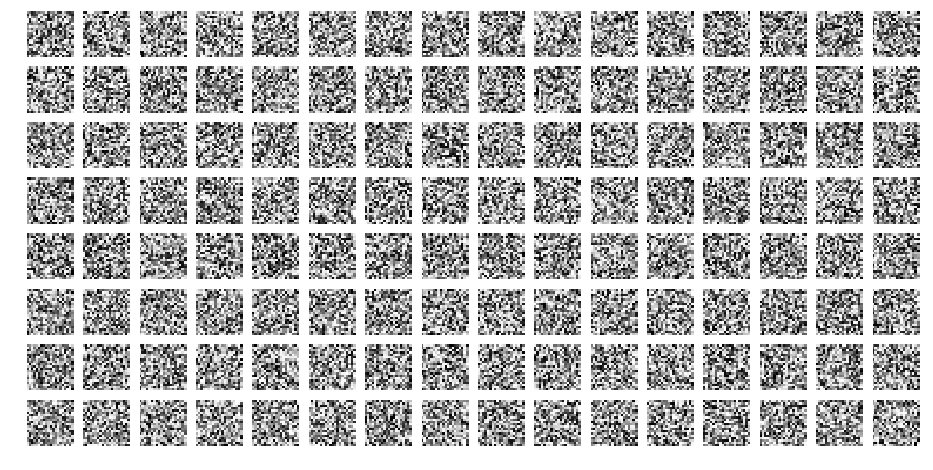

Section 1: Codebook after 1000 iterations


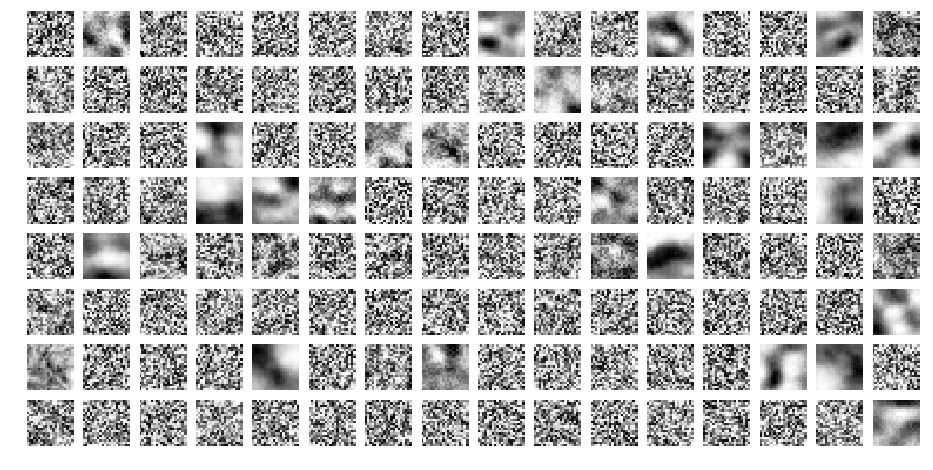

Section 1: Sample reconstructions after 1000 iterations, MSE 0.219


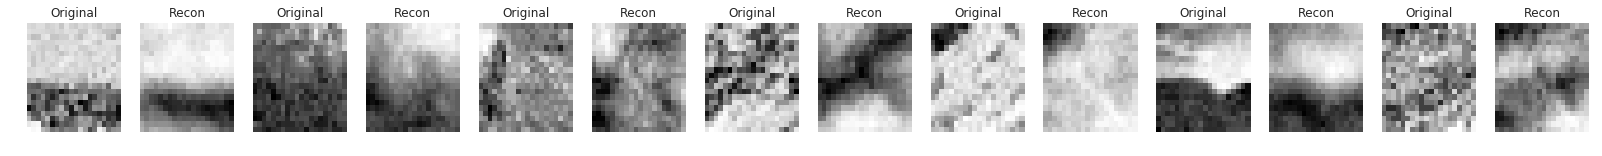

Section 1: Codebook after 2000 iterations


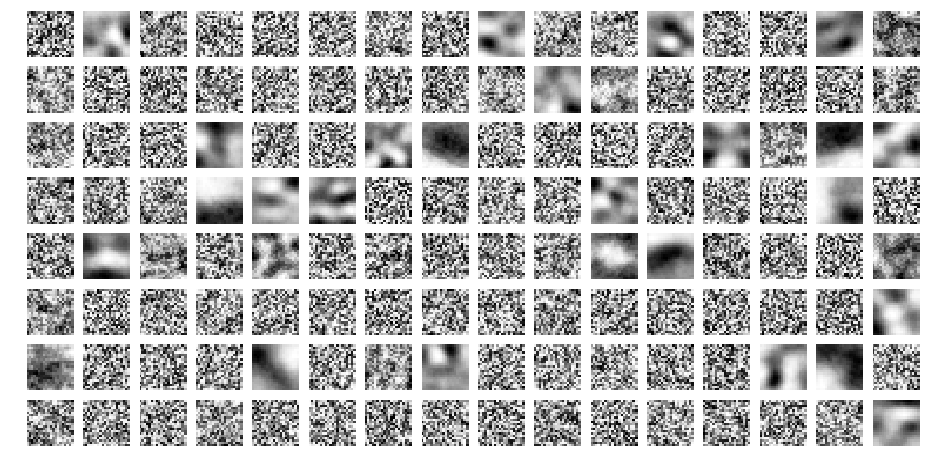

Section 1: Sample reconstructions after 2000 iterations, MSE 0.166


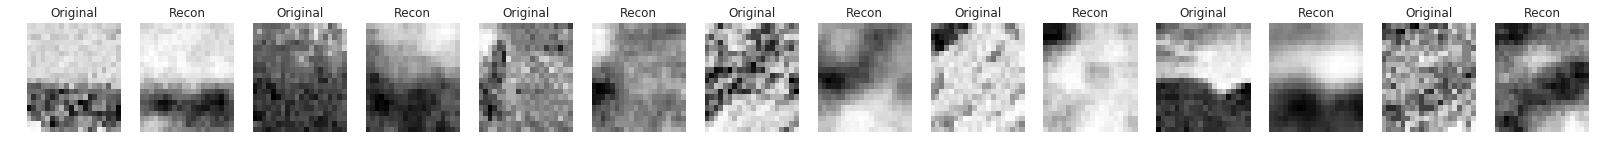

Section 1: Codebook after 3000 iterations


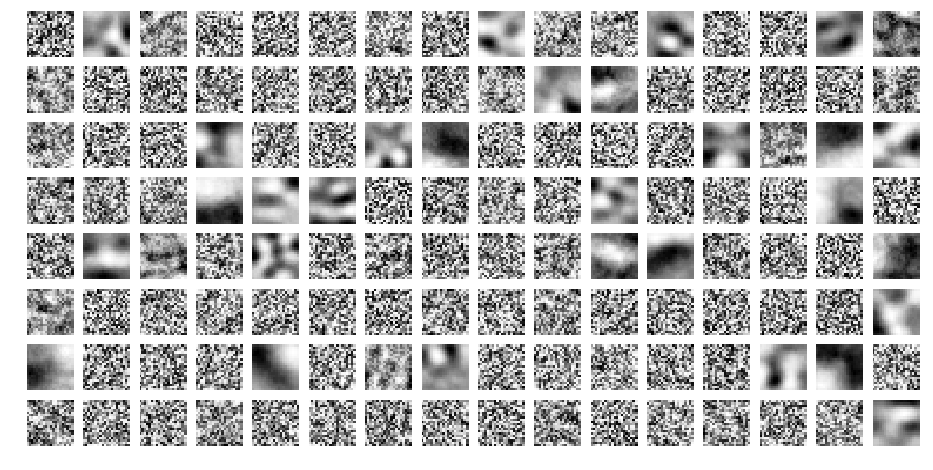

Section 1: Sample reconstructions after 3000 iterations, MSE 0.157


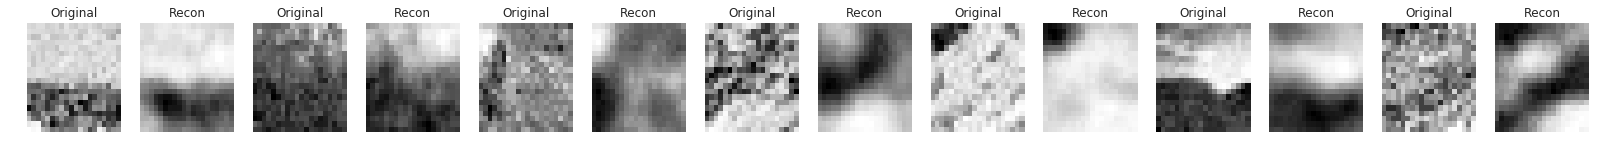

Section 1: Codebook after 4000 iterations


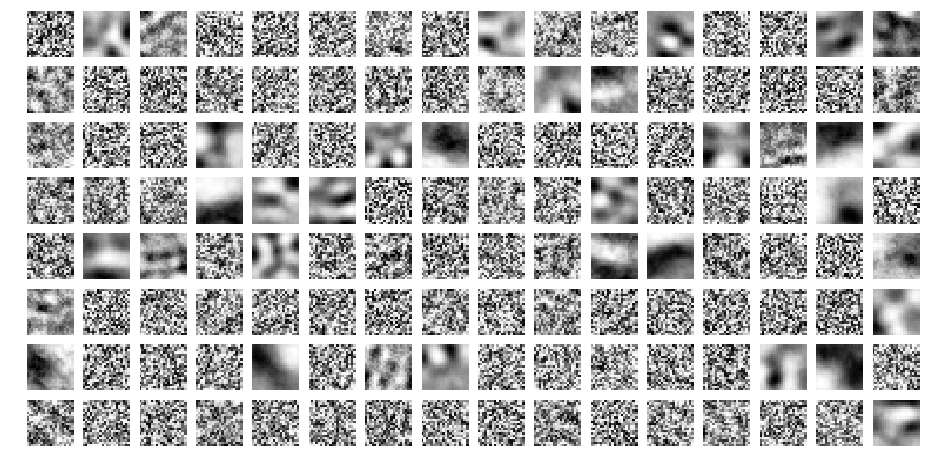

Section 1: Sample reconstructions after 4000 iterations, MSE 0.154


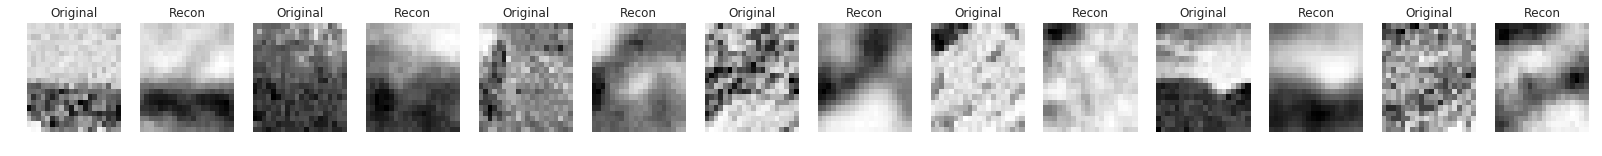

Section 1: Codebook after 5000 iterations


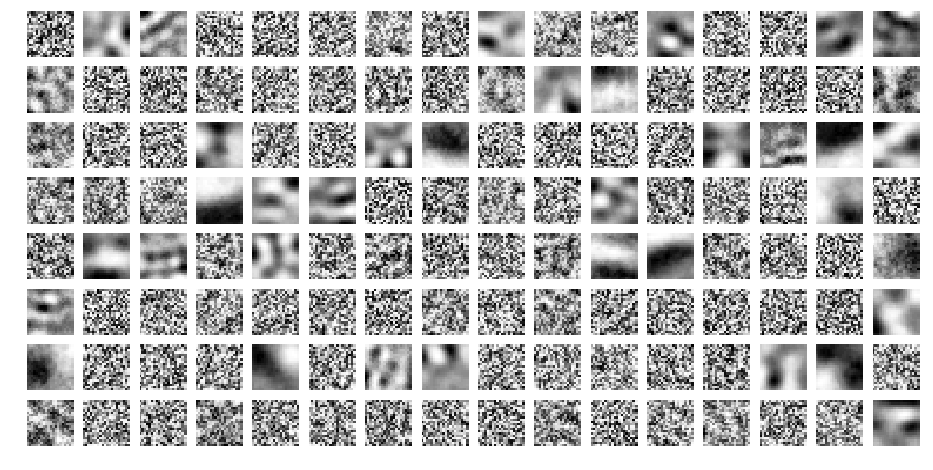

Section 1: Sample reconstructions after 5000 iterations, MSE 0.151


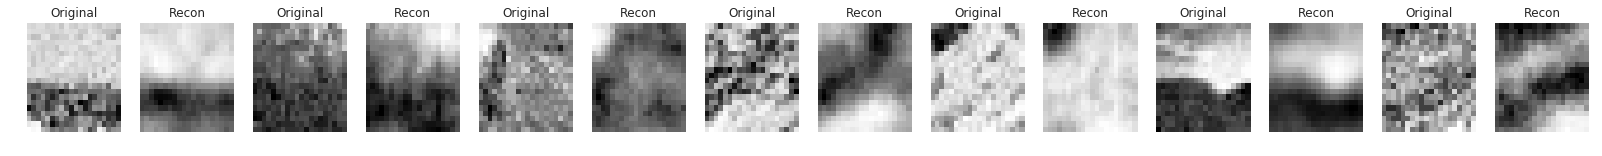

Section 1: Codebook after 6000 iterations


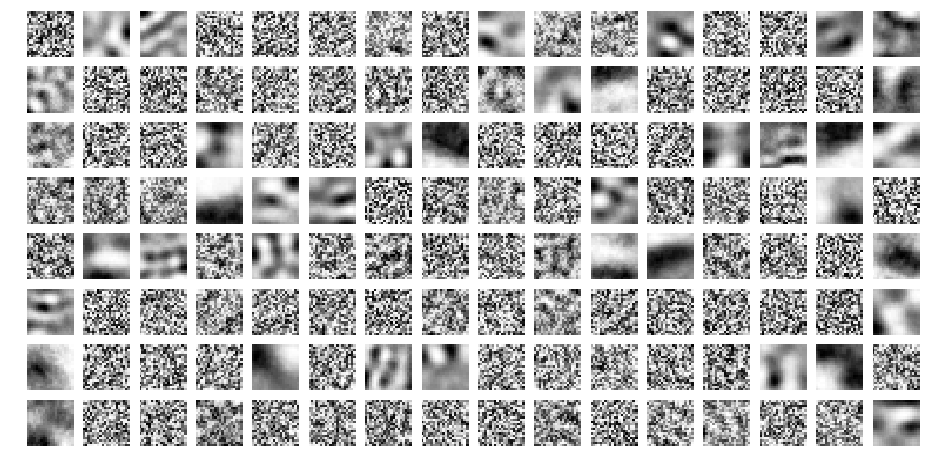

Section 1: Sample reconstructions after 6000 iterations, MSE 0.149


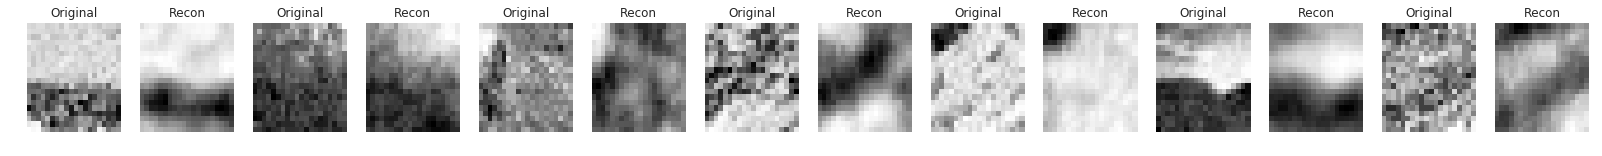

Section 1: Codebook after 7000 iterations


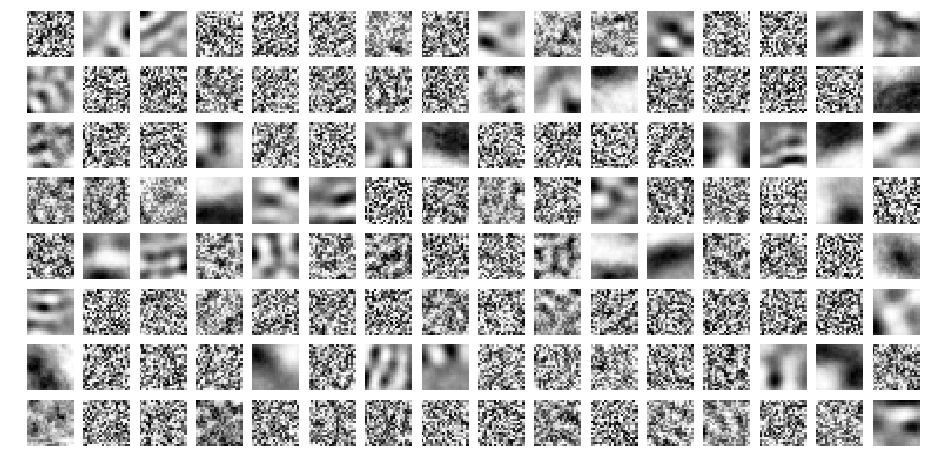

Section 1: Sample reconstructions after 7000 iterations, MSE 0.148


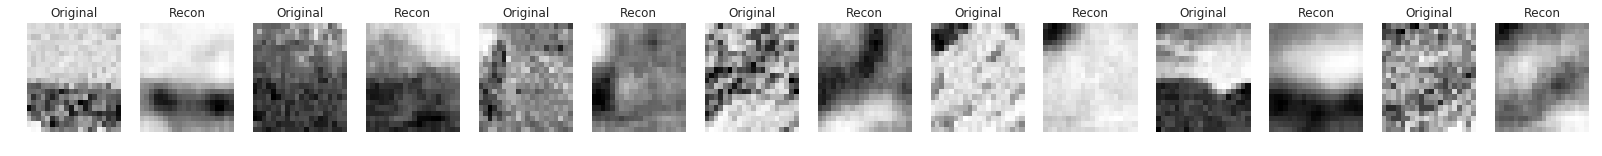

Section 1: Codebook after 8000 iterations


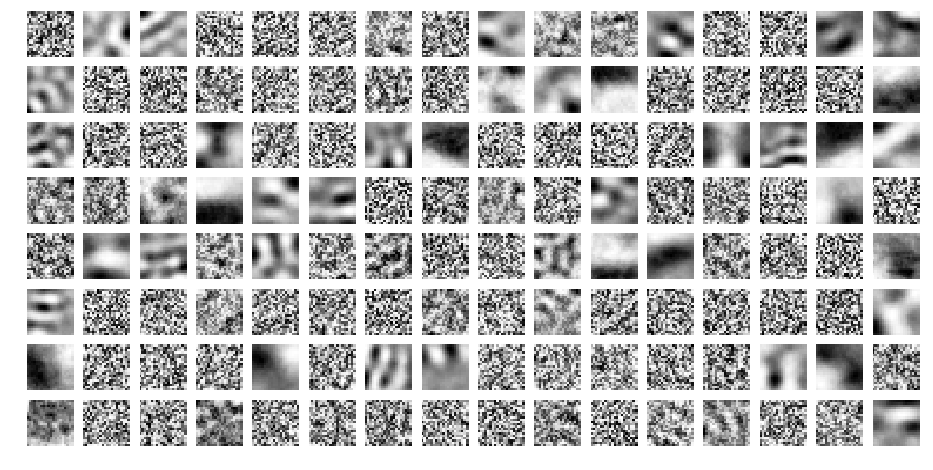

Section 1: Sample reconstructions after 8000 iterations, MSE 0.143


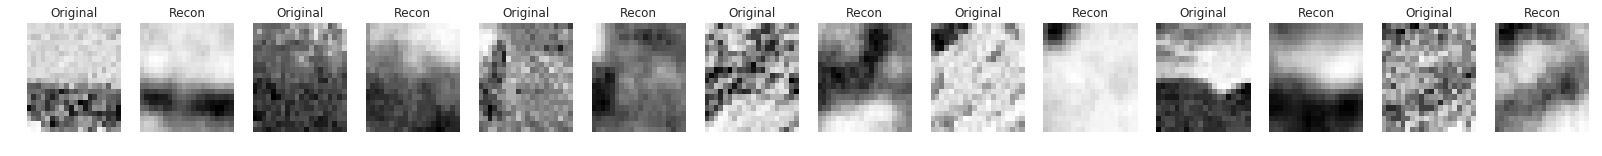

Section 1: Codebook after 9000 iterations


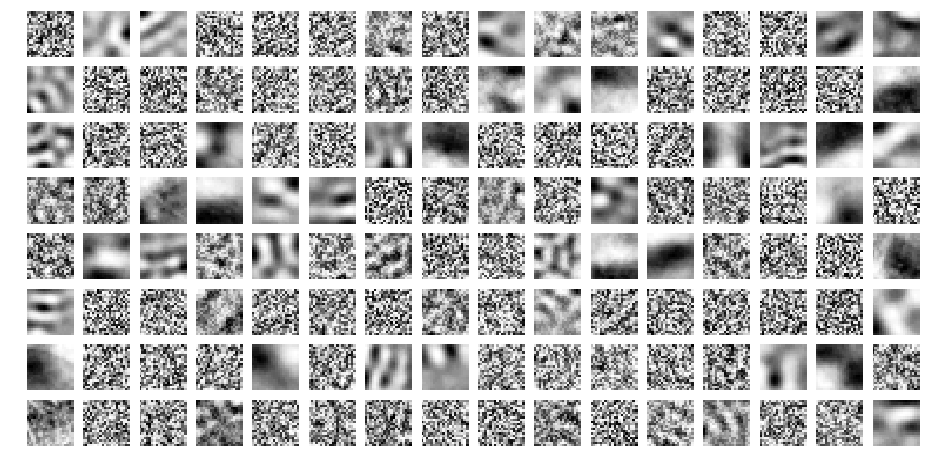

Section 1: Sample reconstructions after 9000 iterations, MSE 0.140


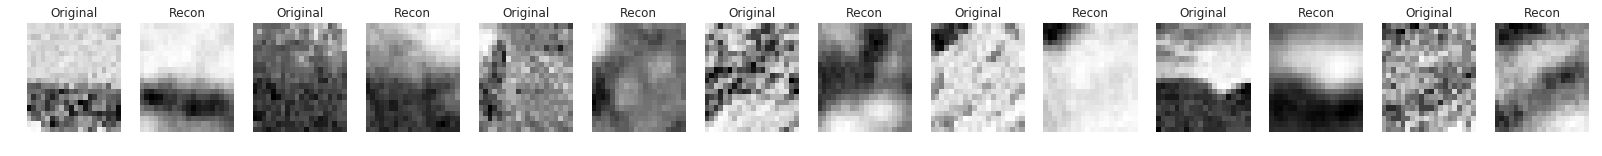

In [ ]:
X, errors = section1Run(images, 1000, 10, 128, 20, 10, .0001)

In [ ]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.scatter(range(len(errors)), errors)
ax.set_title("Section 1: Sample Reconstruction MSE vs Number of Iterations", fontsize=20)
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Sample Reconstruction MSE')
plt.show()

The above graph shows that the error mostly stabalizes after 3000 iterations. This does depend heavily on eta. We experemented with a large range of etas and settle on the current value of .0001 as it is not too slow and has still has lower noise. We also found the use of random noise to intilize worked better than random samples since those would get "stuck" more easily. 

The atoms that do develop appear about as expected, a little more complex than those shown in the original paper, but that could be do to a different beta generation proccess or different dictionary size. What they appear to represent are small features, such as edges, lines or dots. What these mean for the reconstruction is they are doing a good job of reducing noise, since they are selecting the macro trends over the minor variations. What is also interesting is that some of them are not developing, this means we have found a local minuma. Since mearly making one of the samples into a node would result in a slightly reduced error level than the current one.

# Section 2

In [17]:
np.random.seed(seed = 123)

In [18]:
dfclean = spark.read.json('/project/cmsc25025/mnist/data.json')

In [19]:
df = dfclean#.sample(False, .001, seed=123)

In [20]:
def reg(x):
    v = np.array(x['features'])
    return (v - v.mean()) / v.std()

regged = df.rdd.map(reg).cache()

In [21]:
def runNiters2(X, img, iters, numSamples, eta):
    errors = []
    for i in range(iters):
        samples = [img[np.random.randint(0, len(img))] for i in range(numSamples)]
        g = getG(X, samples)
        X -= eta * g
        X = np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis = 1, arr =  X)
        errors.append(np.mean([getError(X, s) for s in samples]))
    return X, errors

In [22]:
def section2Run(imgRDD, iterStep, numSteps, codebookSize, numSamples, eta):
    #X = np.stack(imgRDD.takeSample(False, codebookSize, seed=123))
    
    displaySamples = imgRDD.takeSample(False, 7, seed = 12)
    
    X = np.random.rand(codebookSize, displaySamples[0].shape[0])
    X = np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis = 1, arr =  X)
    print("Section 2: Intial Codebook ({} atoms)".format(codebookSize))
    displayCodebook(X)
    #Much faster than working with the RDD, even after caching
    img = imgRDD.collect()
    errors = []
    for i in range(numSteps):
        XRun, errRun = runNiters2(X, img, iterStep, numSamples, eta)
        X = XRun
        errors += errRun
        
        #matplotlib didn't give nice titles
        
        print("Section 2: Codebook after {} iterations".format(iterStep * (i + 1)))
        displayCodebook(X)
        
        print("Section 2: Sample reconstructions after {} iterations, MSE {:.3f}".format(iterStep * (i + 1), np.mean(errRun)))
        compareRec(X, displaySamples)
    return X, errors

Section 2: Intial Codebook (32 atoms)


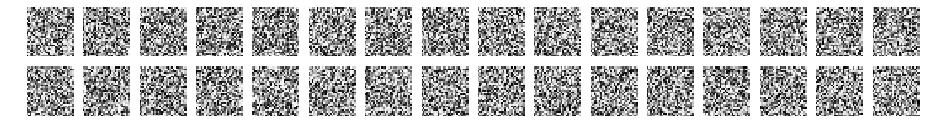

Section 2: Codebook after 500 iterations


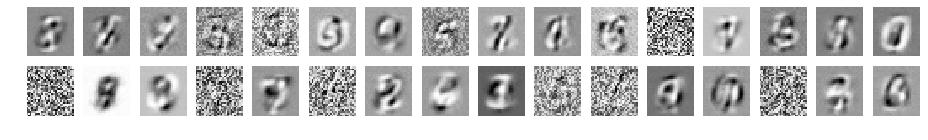

Section 2: Sample reconstructions after 500 iterations, MSE 0.368


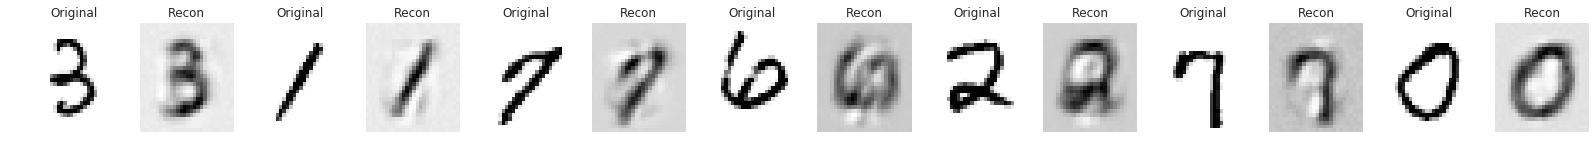

Section 2: Codebook after 1000 iterations


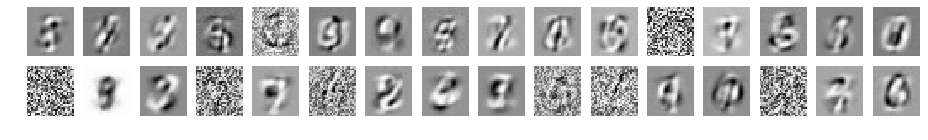

Section 2: Sample reconstructions after 1000 iterations, MSE 0.281


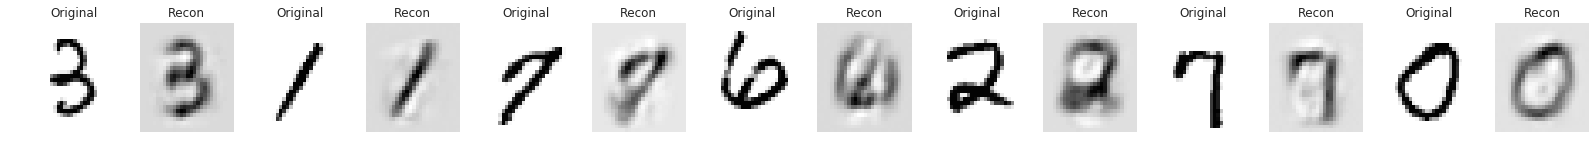

Section 2: Codebook after 1500 iterations


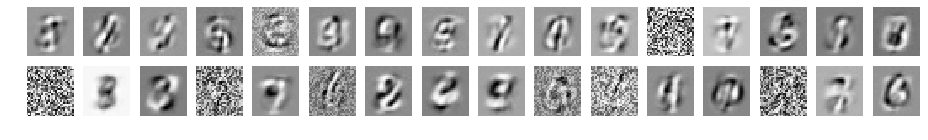

Section 2: Sample reconstructions after 1500 iterations, MSE 0.272


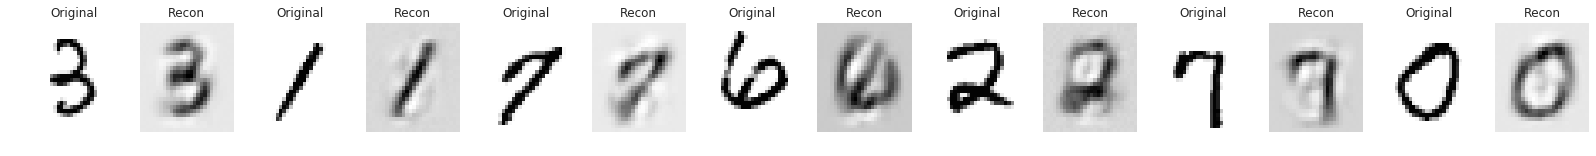

Section 2: Codebook after 2000 iterations


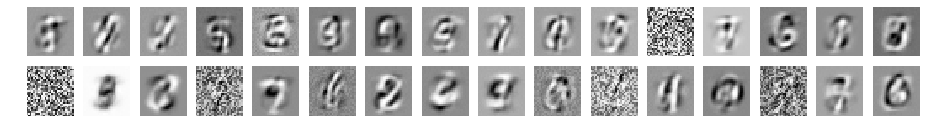

Section 2: Sample reconstructions after 2000 iterations, MSE 0.262


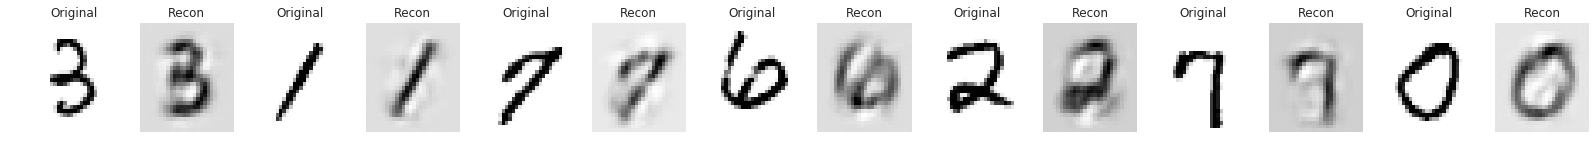

Section 2: Codebook after 2500 iterations


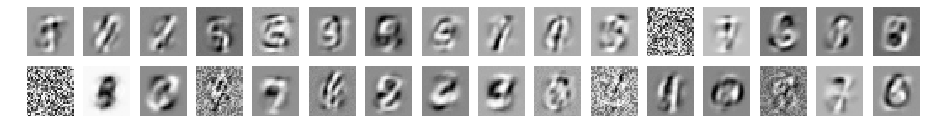

Section 2: Sample reconstructions after 2500 iterations, MSE 0.254


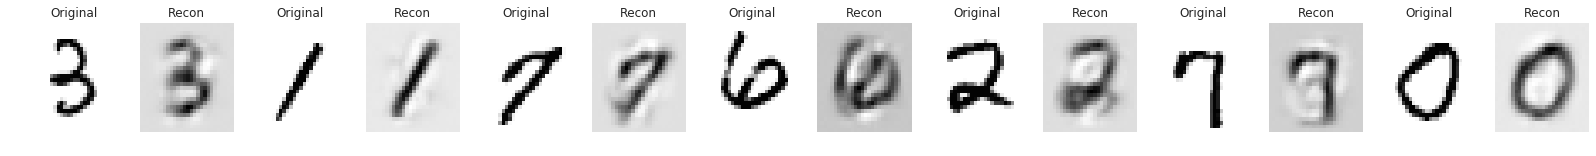

In [26]:
X, errors = section2Run(regged, 500, 5, 32, 10, .0001)

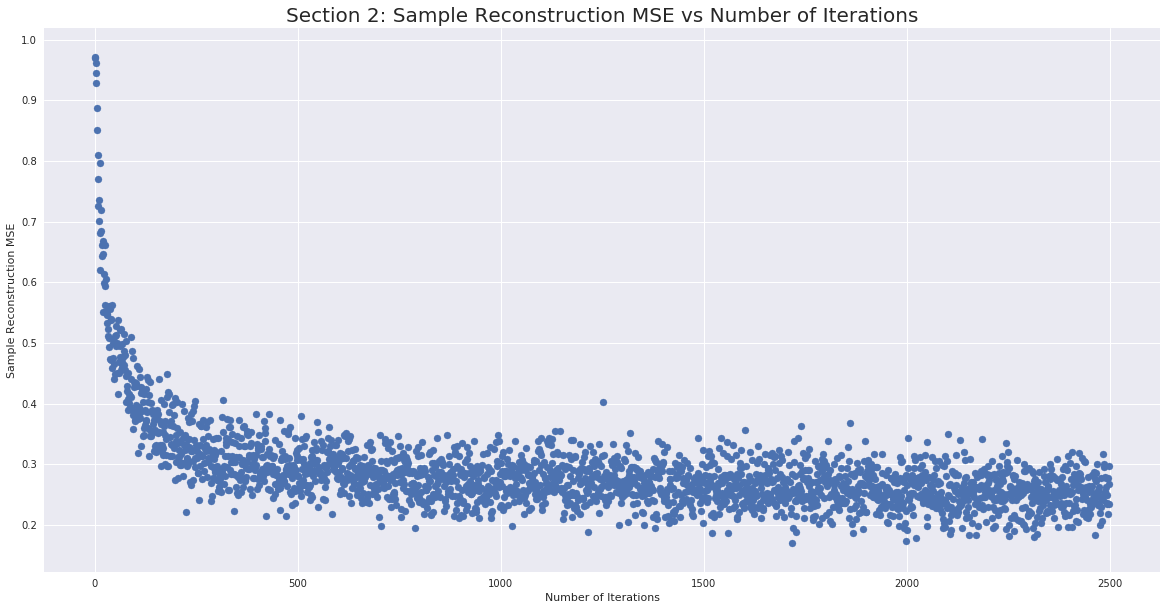

In [27]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.scatter(range(len(errors)), errors)
ax.set_title("Section 2: Sample Reconstruction MSE vs Number of Iterations", fontsize=20)
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Sample Reconstruction MSE')
plt.show()

The above graph shows that the MSE mostly stabilzes after 200 iterations, but continues to improve slightly for another 500 or so, it's asymtotic so definining the exact plateau point is hard. What is intersting though is that this is only a local minuma. There are about 4 codebook words that are still mostly noise, these could likely be developed further, but that would require escaping the local minuma.

The code words that do develop appear quite similar to those in PCA. They have some semblence to a single digit but with one or two features amplified and maybe some additional ones. The lack of orthogonality appears to be the main difference as some of these are very similar, e.g. mutiple slanted 1 shapes.

This run was done with the same Orthogonal Matching Pursuit as section 1 and beta was created from the top 10 atom. It is likely 10 is too small for this codebook size as and that increasing it would allow more atoms to develop.